# Tanzanian Water Pump Analysis with Machine Learning

Author: Brandon Sienkiewicz

## Overview

Over sixty-one million people currently reside in Tanzania and, as a developing nation, access to clean water has become a major concern. Tanzania has a history of limited access to clean water sources and water sanitation resourses. This especially holds true for rural populations. There have been efforts in recent years in order to improve the water infrastructure, there is still much work to be done to bring clean water resources to the people of Tanzania. In addition to the issues with the overall infrastructure, maintainence of water wells has also proven to be an issue. Due to low tariffs and poor efficiency, many water wells need repaired or have completely failed. This is a glaring issue. If infrastructure improves but there is no way to maintain water wells, then the situation in Tanzania will not vastly improve.

## Business Understanding

As mentioned above, access to clean water in Tanzania is a major issue and the upkeep of wells is an issue that needs to be tackled first. In order to tackle this problem, we need to locate the wells in need of repair. My goal is to create a model that can accurately predict the location of wells in need of repair. This model will provide a more thoughrough understanding of which points will fail and will allow for better overall maintenance operations. This will help to limit NGO resources as well as provide a larger impact on providing clean water to the people of Tanzania. To achieve this goal, I utilized data from Taarifa and the Tanzanian Ministry of Water to create machine learning models that predict the state of wells throughout Tanzania.

## Exploratory Data Analysis

In [14]:
import pandas as pd
import numpy as np
import math
import xgboost

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler,\
FunctionTransformer

from sklearn.pipeline import Pipeline

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.compose import ColumnTransformer,  make_column_selector as selector

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, \
AdaBoostClassifier, GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

In [15]:
sub = pd.read_csv('data/SubmissionFormat.csv')
X_te = pd.read_csv('data/TestSetValues.csv')
train_label = pd.read_csv('data/TrainingSetLabels.csv')
X_t = pd.read_csv('data/TrainingSetValues.csv')

In [16]:
X_te.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [17]:
train_label.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [18]:
y_train = train_label.status_group

In [19]:
analysis_df = pd.merge(X_t, train_label, on='id')

In [20]:
X_t.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [21]:
categorical = selector(dtype_include=object)
X_t_cat = X_t[categorical(X_t)]

for x in X_t_cat:
    print('{}: {} unique values'.format(x, len(X_t_cat[x].unique())))

date_recorded: 356 unique values
funder: 1898 unique values
installer: 2146 unique values
wpt_name: 37400 unique values
basin: 9 unique values
subvillage: 19288 unique values
region: 21 unique values
lga: 125 unique values
ward: 2092 unique values
public_meeting: 3 unique values
recorded_by: 1 unique values
scheme_management: 13 unique values
scheme_name: 2697 unique values
permit: 3 unique values
extraction_type: 18 unique values
extraction_type_group: 13 unique values
extraction_type_class: 7 unique values
management: 12 unique values
management_group: 5 unique values
payment: 7 unique values
payment_type: 7 unique values
water_quality: 8 unique values
quality_group: 6 unique values
quantity: 5 unique values
quantity_group: 5 unique values
source: 10 unique values
source_type: 7 unique values
source_class: 3 unique values
waterpoint_type: 7 unique values
waterpoint_type_group: 6 unique values


In [22]:
dropped_features = [
    'id',
    'management',
    'payment_type',
    'water_quality',
    'quantity',
    'waterpoint_type_group',
    'source',
    'source_type',
    'extraction_type',
    'extraction_type_group',
    'scheme_name',
    'recorded_by',
    'ward',
    'district_code',
    'region_code',
    'subvillage',
    'num_private',
    'wpt_name',
    'latitude',
    'longitude',
    'funder',
    'installer',
    'date_recorded',
    'public_meeting'
]

In [23]:
X_train = X_t.drop(dropped_features, 
                   axis=1)

X_test = X_te.drop(dropped_features,
                  axis=1)

analysis_df = analysis_df.drop(dropped_features,
                  axis=1)

In [24]:
analysis_df

,amount_tsh,gps_height,basin,region,lga,population,scheme_management,permit,construction_year,extraction_type_class,management_group,payment,quality_group,quantity_group,source_class,waterpoint_type,status_group
0,6000.0,1390,Lake Nyasa,Iringa,Ludewa,109,VWC,False,1999,gravity,user-group,pay annually,good,enough,groundwater,communal standpipe,functional
1,0.0,1399,Lake Victoria,Mara,Serengeti,280,Other,True,2010,gravity,user-group,never pay,good,insufficient,surface,communal standpipe,functional
2,25.0,686,Pangani,Manyara,Simanjiro,250,VWC,True,2009,gravity,user-group,pay per bucket,good,enough,surface,communal standpipe multiple,functional
3,0.0,263,Ruvuma / Southern Coast,Mtwara,Nanyumbu,58,VWC,True,1986,submersible,user-group,never pay,good,dry,groundwater,communal standpipe multiple,non functional
4,0.0,0,Lake Victoria,Kagera,Karagwe,0,NaN,True,0,gravity,other,never pay,good,seasonal,surface,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,1210,Pangani,Kilimanjaro,Hai,125,Water Board,True,1999,gravity,user-group,pay per bucket,good,enough,groundwater,communal standpipe,functional
59396,4700.0,1212,Rufiji,Iringa,Njombe,56,VWC,True,1996,gravity,user-group,pay annually,good,enough,surface,communal standpipe,functional
59397,0.0,0,Rufiji,Mbeya,Mbarali,0,VWC,False,0,handpump,user-group,pay monthly,fluoride,enough,groundwater,hand pump,functional
59398,0.0,0,Rufiji,Dodoma,Chamwino,0,VWC,True,0,handpump,user-group,never pay,good,insufficient,groundwater,hand pump,functional


In [25]:
X_train.head()

,amount_tsh,gps_height,basin,region,lga,population,scheme_management,permit,construction_year,extraction_type_class,management_group,payment,quality_group,quantity_group,source_class,waterpoint_type
0,6000.0,1390,Lake Nyasa,Iringa,Ludewa,109,VWC,False,1999,gravity,user-group,pay annually,good,enough,groundwater,communal standpipe
1,0.0,1399,Lake Victoria,Mara,Serengeti,280,Other,True,2010,gravity,user-group,never pay,good,insufficient,surface,communal standpipe
2,25.0,686,Pangani,Manyara,Simanjiro,250,VWC,True,2009,gravity,user-group,pay per bucket,good,enough,surface,communal standpipe multiple
3,0.0,263,Ruvuma / Southern Coast,Mtwara,Nanyumbu,58,VWC,True,1986,submersible,user-group,never pay,good,dry,groundwater,communal standpipe multiple
4,0.0,0,Lake Victoria,Kagera,Karagwe,0,NaN,True,0,gravity,other,never pay,good,seasonal,surface,communal standpipe


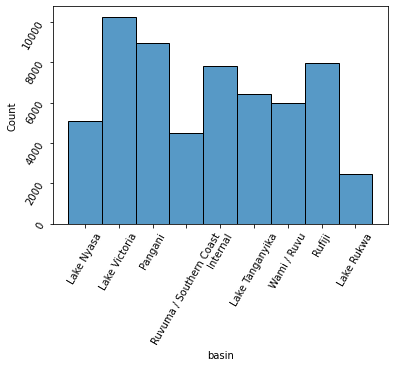

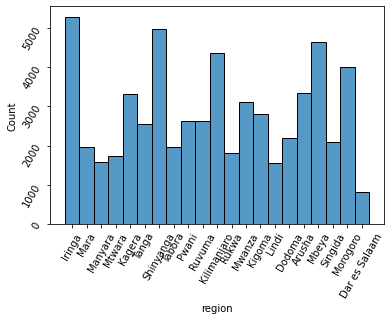

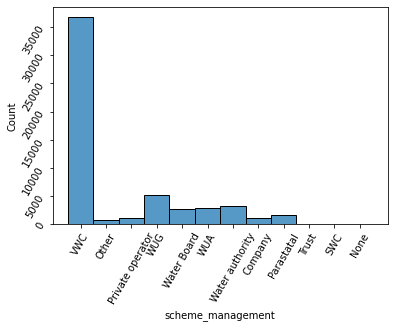

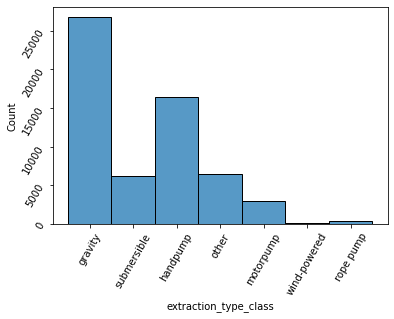

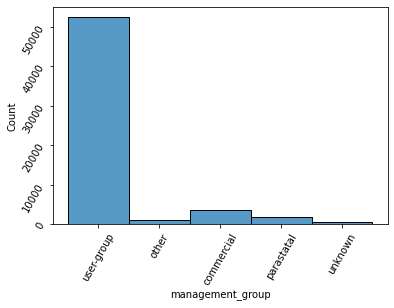

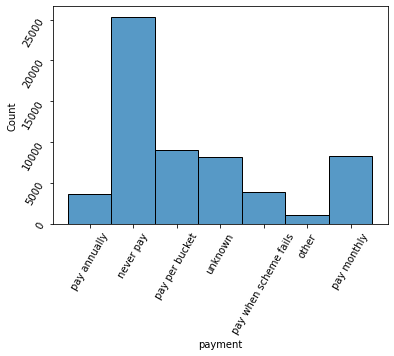

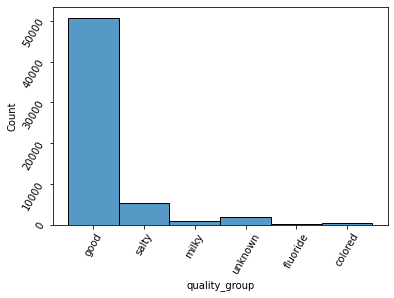

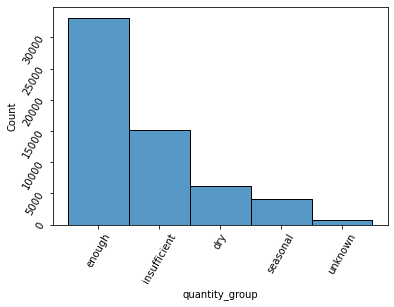

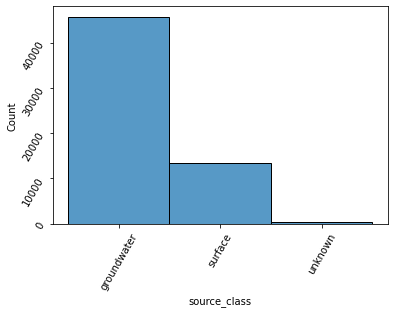

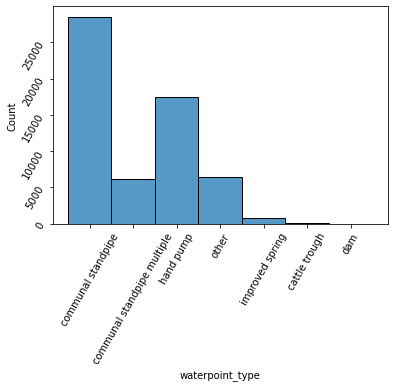

In [27]:
categorical_train = selector(dtype_include=object)
X_train_cat = X_train[categorical_train(X_train)]
X_train_cat = X_train_cat.drop(['permit', 'lga'], axis=1)

for x in X_train_cat:
        
    sns.histplot(x=X_train_cat[x])
    plt.tick_params(labelrotation=60)
    plt.show()

In [28]:
def status_compare(column):

    dfs = []
    functional_dict = {'status':'functional'}
    repair_dict = {'status':'repair'}
    nonfunctional_dict = {'status':'nonfunctional'}

    for x,y in zip(analysis_df[column],
                   analysis_df.status_group):
        if y == 'functional':
            if x not in functional_dict.keys():
                functional_dict[str(x)] = 1
            else:
                functional_dict[str(x)] += 1
        elif y == 'functional needs repair':
            if x not in repair_dict.keys():
                repair_dict[str(x)] = 1
            else:
                repair_dict[str(x)] += 1
        else: 
            if x not in nonfunctional_dict.keys():
                nonfunctional_dict[str(x)] = 1
            else:
                nonfunctional_dict[str(x)] += 1

        globals()[f'{column}_df'] = pd.DataFrame([
            functional_dict,
            repair_dict,
            nonfunctional_dict
        ],index=range(3))

### create as a dictionary to call the variables

In [29]:
status_compare('basin')
basin_df

,status,Lake Nyasa,Lake Victoria,Pangani,Wami / Ruvu,Internal,Lake Tanganyika,Ruvuma / Southern Coast,Rufiji,Lake Rukwa
0,functional,3324,5100,5372,3136,4482,3107,1670,5068,1000
1,repair,250,989,477,269,557,742,326,437,270
2,nonfunctional,1511,4159,3091,2582,2746,2583,2497,2471,1184


In [30]:
for cat in X_train_cat:
    status_compare(cat)
    
## Note: This cell take a few minutes to run

KeyboardInterrupt: 

In [ ]:
feature_dfs = [
    basin_df,
    region_df,
    scheme_management_df,
    extraction_type_class_df,
    management_group_df,
    payment_df,
    quality_group_df,
    quantity_group_df,
    source_class_df,
    waterpoint_type_df
]

In [ ]:
for df in feature_dfs:
    df.dropna(inplace=True)

In [ ]:
for df in feature_dfs:
    for x in df.drop('status', axis=1):
        column_sum = sum(df[x])
        for y in df[x]:
            df.replace(y, y/column_sum, inplace=True)

In [ ]:
waterpoint_type_df

In [ ]:
for df in feature_dfs:
    df.drop('status',axis=1).T.plot.bar(stacked=True)

In [200]:
for x in basin_df.drop('status', axis=1):
    for y in basin_df[x]:
        basin_df.replace(y, (y/sum(basin_df[x])), inplace=True)
        
basin_df

,status,Lake Nyasa,Lake Victoria,Pangani,Wami / Ruvu,Internal,Lake Tanganyika,Ruvuma / Southern Coast,Rufiji,Lake Rukwa
0,functional,0.364156,0.294544,0.346472,0.323754,0.330105,0.283165,0.249966,0.355904,0.255863
1,repair,0.094260,0.129229,0.090321,0.066534,0.112521,0.148156,0.084575,0.099774,0.128829
2,nonfunctional,0.685562,0.702325,0.695944,0.719227,0.693123,0.698598,0.749285,0.686897,0.722082


<AxesSubplot:>

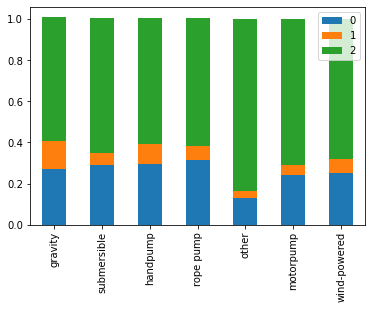

In [155]:
ex_df.drop('status',axis=1).T.plot.bar(stacked=True)

<BarContainer object of 3 artists>

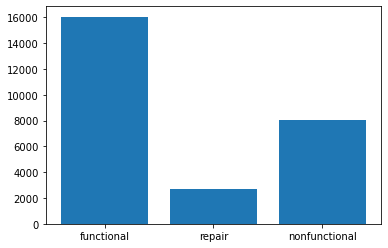

In [123]:
plt.bar(x=ex_df.status, height=ex_df.gravity)

In [89]:
analysis_df.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   gps_height             59400 non-null  int64  
 2   basin                  59400 non-null  object 
 3   region                 59400 non-null  object 
 4   lga                    59400 non-null  object 
 5   population             59400 non-null  int64  
 6   scheme_management      55523 non-null  object 
 7   permit                 56344 non-null  object 
 8   construction_year      59400 non-null  int64  
 9   extraction_type_class  59400 non-null  object 
 10  management_group       59400 non-null  object 
 11  payment                59400 non-null  object 
 12  quality_group          59400 non-null  object 
 13  quantity_group         59400 non-null  object 
 14  source_class           59400 non-null  object 
 15  wa

## Modelling

In [13]:
X_train.construction_year = X_train.construction_year.map(str).astype(object)

In [14]:
numeric_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

category_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [15]:
Preprocessing = ColumnTransformer(transformers=[
    ('num_trans', numeric_pipe, selector(dtype_include=np.number)),
    ('cat_trans', category_pipe, selector(dtype_include=object))
],remainder='passthrough')

In [17]:
class Evaluation():
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y

        self.cv_results = None
        self.cv_mean = None
        self.cv_std = None

        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

In [21]:
baseline_model = Pipeline([
    ('preprocessing', Preprocessing),
    ('Baseline', DummyClassifier(strategy='most_frequent'))
])

baseline_model_pipe = Evaluation(baseline_model,model_name='Basline',X=X_train,y=y_train)

baseline_model_pipe.print_cv_summary()

CV Results for `Basline` model:
            0.54308 ± 0.00005 accuracy
        


In [19]:
classifiers = [
    LogisticRegression(max_iter=10000),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    xgboost.XGBClassifier()
]

i=0

mod_name = [
    'Logistic_Regression',
    'KNN',
    'Decision_Tree',
    'Random_Forest',
    'GradientBoosting',
    'AdaBoost',
    'XGBoost'
]

for classifier in classifiers:
    
    model = Pipeline([
        ('preprocessing', Preprocessing),
        (mod_name[i], classifier)
    ])
    
    model_pipe = Evaluation(model,model_name=mod_name[i], X=X_train, y=y_train)
    
    model_pipe.print_cv_summary()
    
    i += 1

CV Results for `Logistic_Regression` model:
            0.74643 ± 0.00654 accuracy
        
CV Results for `KNN` model:
            0.77145 ± 0.00475 accuracy
        
CV Results for `Decision_Tree` model:
            0.75631 ± 0.00633 accuracy
        
CV Results for `Random_Forest` model:
            0.78731 ± 0.00635 accuracy
        
CV Results for `GradientBoosting` model:
            0.74613 ± 0.00547 accuracy
        
CV Results for `AdaBoost` model:
            0.71668 ± 0.00520 accuracy
        
CV Results for `XGBoost` model:
            0.78109 ± 0.00489 accuracy
        


In [213]:
params_rf = {
    'rand_forest__n_estimators':[25,50,75,250],
    'rand_forest__max_features':['auto',10, 20, 30, 40],
    'rand_forest__min_samples_leaf':[1, 3, 5, 10],
    'rand_forest__bootstrap':[True, False],
    'rand_forest__min_samples_split':[2,5,10]
}

In [214]:
params_rf = {
    'rand_forest__n_estimators':[250, 500, 750, 1000, 2500],
    'rand_forest__max_features':['auto'],
    'rand_forest__min_samples_leaf':[1],
    'rand_forest__bootstrap':[True],
    'rand_forest__min_samples_split':[10, 20, 30, 40, 50]
}

In [ ]:
params_rf = {
    'rand_forest__n_estimators':[200, 250, 300],
    'rand_forest__max_features':['auto'],
    'rand_forest__min_samples_leaf':[1],
    'rand_forest__bootstrap':[True],
    'rand_forest__min_samples_split':[7,10,15]
}

In [ ]:
params_rf = {
    'rand_forest__n_estimators':[100,125,150,175,200,225],
    'rand_forest__oob_score':[True],
    'rand_forest__min_samples_split':[8,9,10,11,12]
}

In [ ]:
gs_rf = GridSearchCV(estimator=rand_forest_model, param_grid=params_rf, verbose=1)

In [ ]:
final_model = Pipeline([
    ('preprossesing', Preprocessing),
    ('test', RandomForestClassifier(bootstrap=True,
                                     min_samples_split=9,
                                     n_estimators=135,
                                    oob_score=True))
])

final_pipe = Evaluation(final_model,model_name='test',X=X_train, y=y_train)

final_pipe.print_cv_summary()

In [ ]:
final_model.fit(X_train, y_train)

In [ ]:
y_pred = final_model.predict(X_test.drop('id', axis=1))

In [ ]:
sub.to_csv('submission.csv', index=False)